# Seq2Seq GRU with Bahdanau Attention for english to german translation.
### Dataset: [Link](http://www.manythings.org/anki/)
### Paper: [Link](https://arxiv.org/abs/1409.0473)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, CuDNNLSTM, Bidirectional, GRU, CuDNNGRU, RepeatVector, Dot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import unicodedata
import re
import time
import os

# Eager execution
tf.enable_eager_execution()

In [0]:
D_PATH = './data/deu.txt'
EPOCHS=10
BATCH_SIZE=64
EMBEDDING_DIM = 256
HIDDEN_DIM=1024
NUM_SAMPLES = 30000
USE_TEACHER_FORCING = True

## Load and preprocess data

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_text(txt):
    txt = unicode_to_ascii(txt.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    txt = re.sub(r"([?.!,¿])", r" \1 ", txt)
    txt = re.sub(r'[" "]+', " ", txt)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    txt = re.sub(r"[^a-zA-Z?.!,¿]+", " ", txt)
    
    txt = txt.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    txt = '<START> ' + txt + ' <END>'
    return txt

In [0]:
class Language:
    def __init__(self, lng):
        self.word2ix = {}
        self.ix2word = {}
        self.vocab = set()
        
        self._create_index(lng)
      
    def _create_index(self, texts):
        for txt in texts:
            self.vocab.update(txt.split())
        
        self.word2ix = {word:i+1 for i, word in enumerate(self.vocab)}
        self.word2ix['<PAD>'] = 0        
        self.ix2word = {i:word for word, i in self.word2ix.items()}
        self.vocab_len = len(self.word2ix)
        

In [0]:
def load_dataset(d_path, num_samples):
    # Load the data
    lines = open(d_path, 'r', encoding='UTF-8').read().strip().split('\n')
    
    # Create texts
    texts = [[preprocess_text(txt) for txt in l.split('\t')] for l in lines][:min(num_samples, len(lines)-1)]
    inp_texts = [row[0] for row in texts]
    target_texts = [row[1] for row in texts]
    
    # Create language objects
    inp_lng = Language(inp_texts)
    target_lng = Language(target_texts)
    
    # Create tensors
    inp_tensor = [[inp_lng.word2ix[word] for word in txt.split()] for txt in inp_texts]
    target_tensor = [[target_lng.word2ix[word] for word in txt.split()] for txt in target_texts]
    
    # Get max_len
    inp_max_len = max(len(txt) for txt in inp_tensor)
    target_max_len = max(len(txt) for txt in target_tensor)
    
    # Pad the tensors
    inp_tensor = pad_sequences(inp_tensor, inp_max_len, padding='post')
    target_tensor = pad_sequences(target_tensor, target_max_len, padding='post')
    
    return (inp_tensor, inp_lng, inp_max_len), (target_tensor, target_lng, target_max_len)

In [0]:
(inp_tensor, inp_lng, inp_max_len), (target_tensor, target_lng, target_max_len) = load_dataset(D_PATH, NUM_SAMPLES)

In [11]:
print(inp_tensor.shape)
print(target_tensor.shape)

(30000, 11)
(30000, 17)


In [0]:
BUFFER = inp_tensor.shape[0]
NUM_BATCHES = BUFFER // BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((inp_tensor, target_tensor)).shuffle(BUFFER)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## Model 

In [0]:
def lstm(units):
    if tf.test.is_gpu_available():
        return CuDNNLSTM(units, return_sequences=True, return_state=True)
    else:
        return LSTM(units, return_sequences=True, return_state=True)

In [0]:
def gru(units):
    if tf.test.is_gpu_available():
        return CuDNNGRU(units, return_sequences=True, return_state=True)
    else:
        return GRU(units, return_sequences=True, return_state=True)

In [0]:
class EncoderGRU(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, h_dim, batch_size):
        super().__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.gru = gru(h_dim)
        self.batch_size = batch_size
        self.h_dim = h_dim
    
    def call(self, x, hidden):
        x = self.embedding(x)
        out, f_h = self.gru(x, initial_state=hidden)
        return out, f_h
        
    
    def init_encoder_hidden(self):
        return tf.zeros((self.batch_size, self.h_dim))

In [0]:
class BahdanauDecoderGRU(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, h_dim):
        super().__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.gru = gru(h_dim)
        self.fc = Dense(units=vocab_size)
    
        # Attention
        self.Wa = Dense(units=h_dim)
        self.Ua = Dense(units=h_dim)
        self.Va = Dense(units=1)
    
    def call(self, x, dec_hid, enc_out):
        dec_hid_time_axis = tf.expand_dims(dec_hid, axis=1)
        
        # Get score and attention weights
        energies = self.Va(tf.nn.tanh(self.Wa(dec_hid_time_axis) + self.Ua(enc_out)))
        atten_wts = tf.nn.softmax(energies, axis=1)
        
        # Get context
        context = atten_wts * enc_out
        context = tf.reduce_sum(context, axis=1)
        context = tf.expand_dims(context, axis=1)
        
        # Create embeddings and concatenate it
        x = self.embedding(x)
        x = tf.concat([context, x], axis=-1)
        
        out, dec_h = self.gru(x, initial_state=dec_hid)
        
        out = tf.reshape(out, (-1, out.shape[2]))
        fc_out = self.fc(out)
        
        return fc_out, dec_h, atten_wts      

In [0]:
encoder = EncoderGRU(inp_lng.vocab_len, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE)
decoder = BahdanauDecoderGRU(target_lng.vocab_len, EMBEDDING_DIM, HIDDEN_DIM)

In [0]:
optimizer = tf.train.AdamOptimizer()

def loss_fn(target, pred):
    # Due to padding
    mask = 1 - np.equal(target, 0)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target, logits=pred) * mask
    
    return tf.reduce_mean(loss)

In [0]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder = encoder,
                                 decoder = decoder)

In [30]:
for ep in range(EPOCHS):
    tick = time.time()
    total_loss = 0.
    
    enc_hidden = encoder.init_encoder_hidden()
    
    for (batch, (inp, target)) in enumerate(dataset):
        loss = 0.
        
        with tf.GradientTape() as tape:
            enc_out, dec_hidden = encoder(inp, enc_hidden)
            dec_input = tf.expand_dims([target_lng.word2ix['<START>']] * BATCH_SIZE, 1)
            
            if USE_TEACHER_FORCING:
                for t in range(1, target.shape[1]):
                    pred, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)
                    loss += loss_fn(target[:, t], pred)
                    dec_input = tf.expand_dims(target[:, t], axis=1)
            else:
                for t in range(1, target.shape[1]):
                    pred, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)
                    pred = tf.argmax(pred, axis=1)
                    dec_input = pred
            
        
        batch_loss = (loss / int(target.shape[1]))
        total_loss += batch_loss
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print(f'Epoch: {ep+1} Batch: {batch} Loss:{batch_loss:.4f}')
    
    if (ep + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    tock = time.time()
    print(f'Epoch: {ep+1} Loss: {total_loss / NUM_BATCHES:.4f} Time: {tock-tick:.2f}\n')

Epoch: 1 Batch: 0 Loss:3.1740
Epoch: 1 Batch: 100 Loss:1.5088
Epoch: 1 Batch: 200 Loss:1.2700
Epoch: 1 Batch: 300 Loss:1.1228
Epoch: 1 Batch: 400 Loss:0.9385
Epoch: 1 Loss: 1.2485 Time: 188.29

Epoch: 2 Batch: 0 Loss:0.8807
Epoch: 2 Batch: 100 Loss:0.8005
Epoch: 2 Batch: 200 Loss:0.7627
Epoch: 2 Batch: 300 Loss:0.7036
Epoch: 2 Batch: 400 Loss:0.7352
Epoch: 2 Loss: 0.7823 Time: 187.91

Epoch: 3 Batch: 0 Loss:0.4903
Epoch: 3 Batch: 100 Loss:0.5528
Epoch: 3 Batch: 200 Loss:0.5300
Epoch: 3 Batch: 300 Loss:0.4773
Epoch: 3 Batch: 400 Loss:0.3800
Epoch: 3 Loss: 0.5082 Time: 186.70

Epoch: 4 Batch: 0 Loss:0.3312
Epoch: 4 Batch: 100 Loss:0.3196
Epoch: 4 Batch: 200 Loss:0.3394
Epoch: 4 Batch: 300 Loss:0.2878
Epoch: 4 Batch: 400 Loss:0.3497
Epoch: 4 Loss: 0.3351 Time: 186.54

Epoch: 5 Batch: 0 Loss:0.2114
Epoch: 5 Batch: 100 Loss:0.2228
Epoch: 5 Batch: 200 Loss:0.2858
Epoch: 5 Batch: 300 Loss:0.2344
Epoch: 5 Batch: 400 Loss:0.2780
Epoch: 5 Loss: 0.2370 Time: 186.65

Epoch: 6 Batch: 0 Loss:0.1467


In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
def evaluate(txt, encoder, decoder, inp_lng, target_lng, inp_max_len, target_max_len):
    txt = preprocess_text(txt)
    enc_inp = [inp_lng.word2ix[w] for w in txt.split()]
    enc_inp = pad_sequences([enc_inp], maxlen = inp_max_len, padding='post')
    enc_inp = tf.convert_to_tensor(enc_inp)
    
    enc_hidden = tf.zeros((1, HIDDEN_DIM))
    enc_out, dec_hidden = encoder(enc_inp, enc_hidden)
    dec_inp = tf.expand_dims([target_lng.word2ix['<START>']], axis=0)
    decoded = ''
    attention_plot = np.zeros((target_max_len, inp_max_len))
    
    for t in range(target_max_len):
        pred, dec_hidden, atten_wts = decoder(dec_inp, dec_hidden, enc_out)
        pred_ix = tf.argmax(pred[0]).numpy()
        pred_word = target_lng.ix2word[pred_ix]
        atten_wts = tf.reshape(atten_wts, (-1,))
        attention_plot[t] = atten_wts.numpy()

        decoded += pred_word + ' '
        dec_inp = tf.expand_dims([pred_ix], axis=0)        
        
        if pred_word == '<END>':
            return txt, decoded, attention_plot

In [0]:
def plot_attention(attention, txt, decoded):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='Reds')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + txt.split(), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + decoded.split(), fontdict=fontdict)

    plt.show()

In [0]:
def translate(txt, encoder, decoder, inp_lng, target_lng, inp_max_len, target_max_len):
    txt, decoded, attention_plot = evaluate(txt, encoder, decoder, inp_lng, target_lng, inp_max_len, target_max_len)
    attention = attention_plot[:len(decoded.split()), :len(txt.split())]

    print(f'TEXT: {txt}')
    print(f'TRANSLATED: {decoded}\n')
    plot_attention(attention, txt, decoded)

TEXT: <START> let s go for dinner . <END>
TRANSLATED: gehen wir zu mittag . <END> 



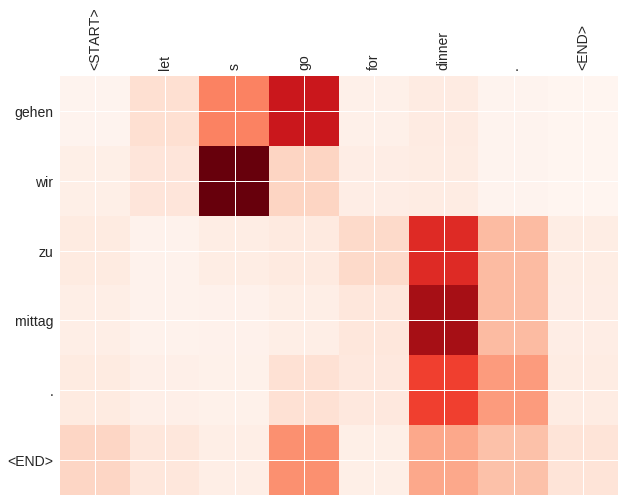

In [69]:
translate("Let's go for dinner.", encoder, decoder, inp_lng, target_lng, inp_max_len, target_max_len)

TEXT: <START> i m very happy with it . <END>
TRANSLATED: ich bin glucklich , ihr glucklich . <END> 



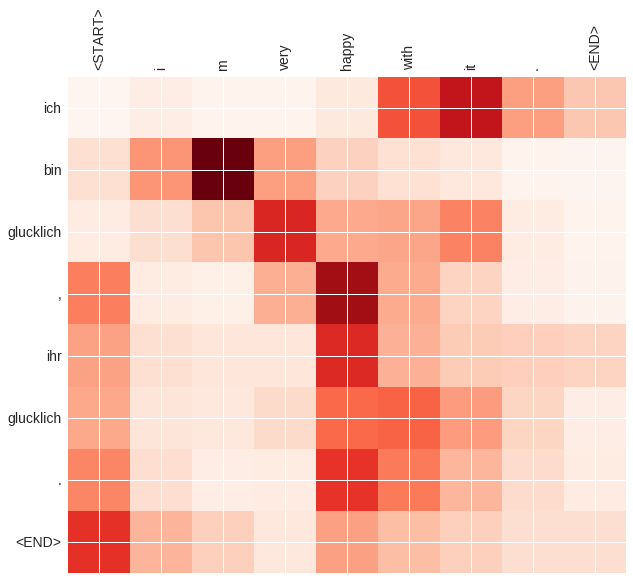

In [70]:
translate("I'm very happy with it.", encoder, decoder, inp_lng, target_lng, inp_max_len, target_max_len)

TEXT: <START> i won t let you escape . <END>
TRANSLATED: ich werde euch nicht bose . <END> 



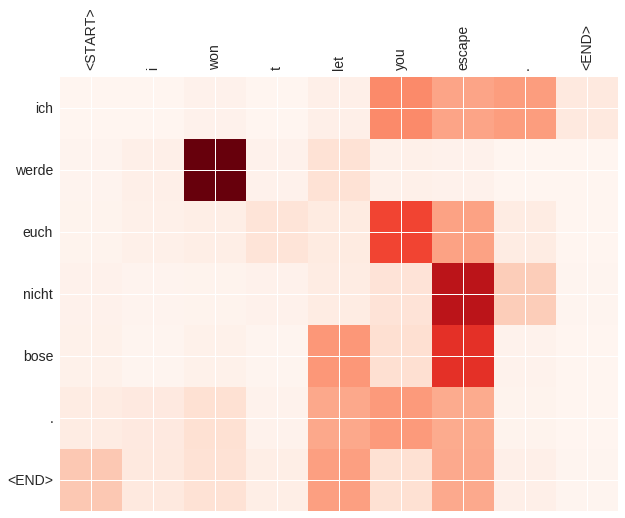

In [71]:
translate("I won't let you escape.", encoder, decoder, inp_lng, target_lng, inp_max_len, target_max_len)

TEXT: <START> he will never hurt me . <END>
TRANSLATED: er wird mich nie etwas schuldig . <END> 



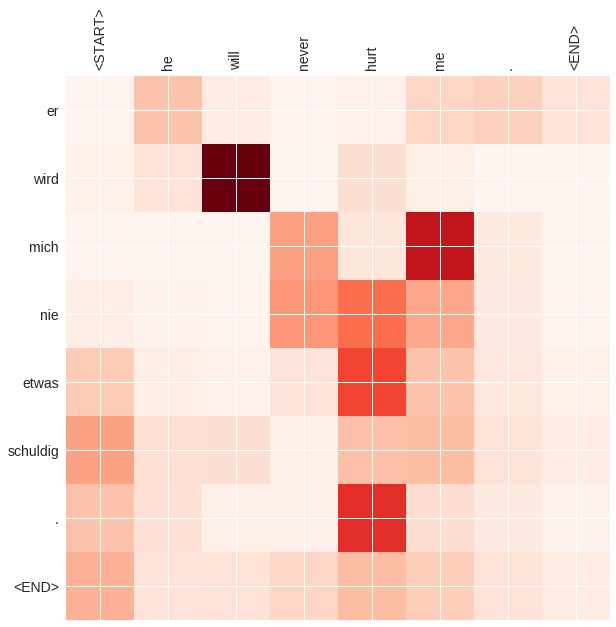

In [72]:
translate("He will never hurt me.", encoder, decoder, inp_lng, target_lng, inp_max_len, target_max_len)